## Airline Dynamic Pricing 

### The problem statement: You recently started Aviato.com, a startup that helps airlines set ticket prices.

Aviato's success will depend on a function called pricing_function. This notebook already includes a very simple version of pricing_function. You will modify pricing_function to maximize the total revenue collected for all flights in our simulated environment.

For each flight, pricing_function will be run once per (simulated) day to set that day's ticket price. The seats you don't sell today will be available to sell tomorrow, unless the flight leaves that day.

Your pricing_function is run for one flight at a time, and it takes following inputs:

Number of days until the flight
Number of seats they have left to sell
A variable called demand_level that determines how many tickets you can sell at any given price.
The quantity you sell at any price is:

quantity_sold = demand_level - price

Ticket quantities are capped at the number of seats available.

Your function will output the ticket price.

You learn the demand_level for each day at the time you need to make predictions for that day. For all days in the future, you only know demand_level will be drawn from the uniform distribution between 100 and 200. So, for any day in the future, it is equally likely to be each value between 100 and 200.

In case this is still unclear, some relevant implementation code is shown below.

This solution uses an optimization technique called dynamic programming. Dynamic programming starts by solving an optimization problem in a very limited scenario, and then creates an iterative rule to expand to larger problem.

In our case, we first solve for the optimal price when you only have 1 day to sell tickets before the flight. Then we continually step back to longer time-horizons one day at a time.

This solution highlights two of the most important ideas from the fields of dynamic programming and reinforcement learning.

The value function returns the best outcome achievable from any input state. In our case, V(tickets_left, days_left) returns the best revenue you can expect to achieve given the number of tickets you have and the number of days left before the flight.
The Q Function is similar to the value function. But it includes your decision as an input, and it returns the expected revenue even if that is not based on an optimal decision policy.
The distinction may become clearer when you see it in practice below.

The output of the Q function for T+1 days before the flight depends how much revenue is the sum of

revenue from flights sold that day
revenue earned in the last T days from the remaining tickets.
Daily revenue is straightforward to calculate (as you'll see below.) Since we calculate Q and the value function (denoted V) start near flight time, and then iteratively work backwards, we can look up revenue from the last T days from the value function.

Once we have Q at time T+1, we calculate V on that day by looking up the revenue associated with the best decision from Q.

Again, this should become clearer as you see it in code.

The Base Case: Selling Tickets For a Single Day
You want to maximize revenue, given the knowledge that

quantity_sold = demand_level - price

You may want to keep the price high rather than sell all remaining tickets. So, this problem is not as trivial as finding the price to sell all available tickets. Instead, you will go back to find the price and quantity pair that maximize

revenue = price * quantity_sold

It's easier to think about optimization in terms of a single choice variable, rather than using an equation that explicitly includes both price and quantity_sold. To do this, first rearrange the quantity_sold equation above with simple algebra to solve for price:

price = demand_level - quantity_sold

Plug this expression for price into the revenue equation and you have

revenue = (demand_level - quantity_sold) * quantity_sold

*note: you could also express revenue entirely in terms of price instead of quantity, but would make a later steps a little messier.

Since demand_level is just a known number when you make your daily price decisions, you can plot revenue as an equation that depends only on the quantity you sell.

For the sake of an example, here is the plot when demand_level is 150.

In [37]:
from numpy.random import uniform, seed
from numpy import floor
from collections import namedtuple
import json
from IPython.display import display,Javascript

## Below code is a simulator of revenue for tickets sold and no of days
- The Simulator
We will run your pricing function in a simulator to test how well it performs on a range of flight situations. Run the following code cell to set up your simulation environment:

In [38]:
def _tickets_sold(p, demand_level, max_qty):
        quantity_demanded = floor(max(0, p - demand_level))
        return min(quantity_demanded, max_qty)

def simulate_revenue(days_left, tickets_left, pricing_function, rev_to_date=0, demand_level_min=100, demand_level_max=200, verbose=False):
    if (days_left == 0) or (tickets_left == 0):
        if verbose:
            if (days_left == 0):
                print("The flight took off today. ")
            if (tickets_left == 0):
                print("This flight is booked full.")
            print("Total Revenue: ${:.0f}".format(rev_to_date))
        return rev_to_date
    else:
        demand_level = uniform(demand_level_min, demand_level_max)
        p = pricing_function(days_left, tickets_left, demand_level)
        q = _tickets_sold(demand_level, p, tickets_left)
        if verbose:
            print("{:.0f} days before flight: "
                  "Started with {:.0f} seats. "
                  "Demand level: {:.0f}. "
                  "Price set to ${:.0f}. "
                  "Sold {:.0f} tickets. "
                  "Daily revenue is {:.0f}. Total revenue-to-date is {:.0f}. "
                  "{:.0f} seats remaining".format(days_left, tickets_left, demand_level, p, q, p*q, p*q+rev_to_date, tickets_left-q))
        return simulate_revenue(days_left = days_left-1,
                              tickets_left = tickets_left-q,
                              pricing_function=pricing_function,
                              rev_to_date=rev_to_date + p * q,
                              demand_level_min=demand_level_min,
                              demand_level_max=demand_level_max,
                              verbose=verbose)

def _save_score(score):
    message = {
        'jupyterEvent': 'custom.exercise_interaction',
        'data': {
            'learnTutorialId': 117,
            'interactionType': "check",
            'questionId': 'Aug31OptimizationChallenge',
            'outcomeType': 'Pass',
            'valueTowardsCompletion': score/10000,
            'failureMessage': None,
            'learnToolsVersion': "Testing"
        }
    }
    js = 'parent.postMessage(%s, "*")' % json.dumps(message)
    display(Javascript(js))

def score_me(pricing_function, sims_per_scenario=200):
    seed(0)
    Scenario = namedtuple('Scenario', 'n_days n_tickets')
    scenarios = [Scenario(n_days=100, n_tickets=100),
                 Scenario(n_days=14, n_tickets=50),
                 Scenario(n_days=2, n_tickets=20),
                Scenario(n_days=1, n_tickets=3),
                 ]
    scenario_scores = []
    for s in scenarios:
        scenario_score = sum(simulate_revenue(s.n_days, s.n_tickets, pricing_function)
                                     for _ in range(sims_per_scenario)) / sims_per_scenario
        print("Ran {:.0f} flights starting {:.0f} days before flight with {:.0f} tickets. "
              "Average revenue: ${:.0f}".format(sims_per_scenario,
                                                s.n_days,
                                                s.n_tickets,
                                                scenario_score))
        scenario_scores.append(scenario_score)
    score = sum(scenario_scores) / len(scenario_scores)
    try:
        _save_score(score)
    except:
        pass
    print("Average revenue across all flights is ${:.0f}".format(score))

## Exercising the price optimization for a given constant demand level and days left 
1. To derive understanding of the dynamic pricing parameters,functions and formulas.
2. TO visualize intial results and understanding

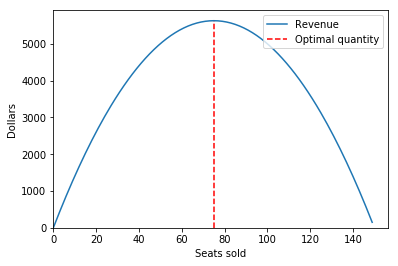

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

demand_level=150

#Plotting the revenue for quantity to check the price points at different demand levels
revenue=[(demand_level-q)*q for q in range(demand_level)]
revenue    

plt.figure()
plt.plot(revenue, label='Revenue')
plt.xlabel('Seats sold')
plt.ylabel('Dollars')

plt.ylim(ymin=0)
plt.xlim(xmin=0)


opt_q=np.argmax(revenue)
plt.vlines(x=opt_q,ymin=0,ymax=max(revenue), color='red',linestyles='--',label='Optimal quantity')
plt.legend(loc='upper right')
# plt.xlabel(demand_level)
# plt.ylabel(revenue)
plt.show()

From the above plot we can say that for a demend level 150, the revenue id maximized when the total no of seats filed is ~78. Thats means for each ticket sold, which is q which is subtracted from the total demand level which gives the price(demand_level-quantity sold(q- which is 1 to 150)) and then multiplied by the quatity sold gives the revenue for that particular demand level. 

Now Below we define different demand levels for different no of days before the flight starrts unlike the above where the no of days is todays and demand level is constant(150) 

In [45]:
n_demand_levels = 11
min_demand_level = 100
max_demand_level = 200
demand_levels = np.linspace(min_demand_level, max_demand_level, n_demand_levels)

max_tickets = 200
max_days = 150

# Q function parameters are: 
#n_sold in day, tickets_left to start day, demand_level, days_left
Q = np.zeros([max_tickets, max_tickets, n_demand_levels, max_days])
# V func parameters are: n_left and n_days
V = np.zeros([max_tickets, max_days])

### The base case: Selling tickets with one day left:
We fill the q value with revenue=price*q_sold as there is only one day left:

Basically what we are trying to do in the below code is:
1. we take differet values for demand levels for different values of days and 
2. Find the optimim price 
3. For each demand_level, choose the optimum number to sell. Output of this is array .of size n_demand_levels and the input the price to the Q function which gives the revenue for different demand levels
4. And then find the average revenue for each demand level.(Price *tickets sold). 
5. We take average since we don't know demand level ahead of time and all are equally likely

- Note:All the code is for one day but different demand levels to get an optimum price point and ultimately optimum revenule for the nof of tickets sold at a given demand level

In [52]:
for tickets_left in range(max_tickets):
    for tickets_sold in range(tickets_left+1): # add 1 to offset 0 indexing. Allow selling all tickets
        for demand_index, demand_level in enumerate(demand_levels):
            # Zerro indicate never set zero prices
            price = max(demand_level - tickets_sold, 0)
            Q[tickets_sold, tickets_left, demand_index, 0] = price * tickets_sold
    # revenue for optimal quantity at every demand level 
    revenue_from_best_quantity_at_each_demand_level = Q[:, tickets_left, :, 0].max(axis=0)
    # take the average, since we don't know demand level ahead of time and all are equally likely
    V[tickets_left, 0] = revenue_from_best_quantity_at_each_demand_level.mean()

### The General Case: Solving for Other Time Horizons
Unlike above we now increase the complexity by iteratively calculating for back time periods.
Observe that in the above V func have no of days as '0'. 
But now it will have 'days_left'
1. The Q function now calculattescurrent revenue but now adds the leftover tickets.

In [47]:
for days_left in range(1, max_days):
    for tickets_left in range(max_tickets):
        for tickets_sold in range(tickets_left):
            for demand_index, demand_level in enumerate(demand_levels):
                price = max(demand_level - tickets_sold, 0)
                rev_today = price * tickets_sold
                Q[tickets_sold, tickets_left, demand_index, days_left] = rev_today + V[tickets_left-tickets_sold, days_left-1]
        expected_total_rev_from_best_quantity_at_each_demand_level = Q[:, tickets_left, :, days_left].max(axis=0)
        V[tickets_left, days_left] = expected_total_rev_from_best_quantity_at_each_demand_level.mean()

We have Q and V. How do we use them?

For any given number of tickets, days_left and demand_level, we look in Q to find the number of tickets with the highest Q-value.

Here is our pricing function that implements that:

In [48]:
def pricing_function(days_left, tickets_left, demand_level):
    demand_level_index = np.abs(demand_level - demand_levels).argmin()
    day_index = days_left - 1 # arrays are 0 indexed
    tickets_index = int(tickets_left)  # in case it comes in as float, but need to index with it
    relevant_Q_vals = Q[:, tickets_index, demand_level_index, day_index]
    desired_quantity = relevant_Q_vals.argmax()# offset 0 indexing
    price = demand_level - desired_quantity
    return price

In [49]:
score_me(pricing_function)

Ran 200 flights starting 100 days before flight with 100 tickets. Average revenue: $18413
Ran 200 flights starting 14 days before flight with 50 tickets. Average revenue: $8492
Ran 200 flights starting 2 days before flight with 20 tickets. Average revenue: $2897
Ran 200 flights starting 1 days before flight with 3 tickets. Average revenue: $431


<IPython.core.display.Javascript object>

Average revenue across all flights is $7558


### Therefor for 200 flights and different days of flight start date and different number of tickets we have optimized the average revenue and concluded the same for different flights